### Dataset and DataLoaders

In [1]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/*/images/*.jpg"))
        self.gt_paths = sorted(glob(f"{root}/*/masks/*.png"))
        self.transformations = transformations
        self.n_cls = 5
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05]):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 8)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 8)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = 8)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 4)


There are 64 number of images in the train set
There are 3 number of images in the validation set
There are 5 number of images in the test set



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualization

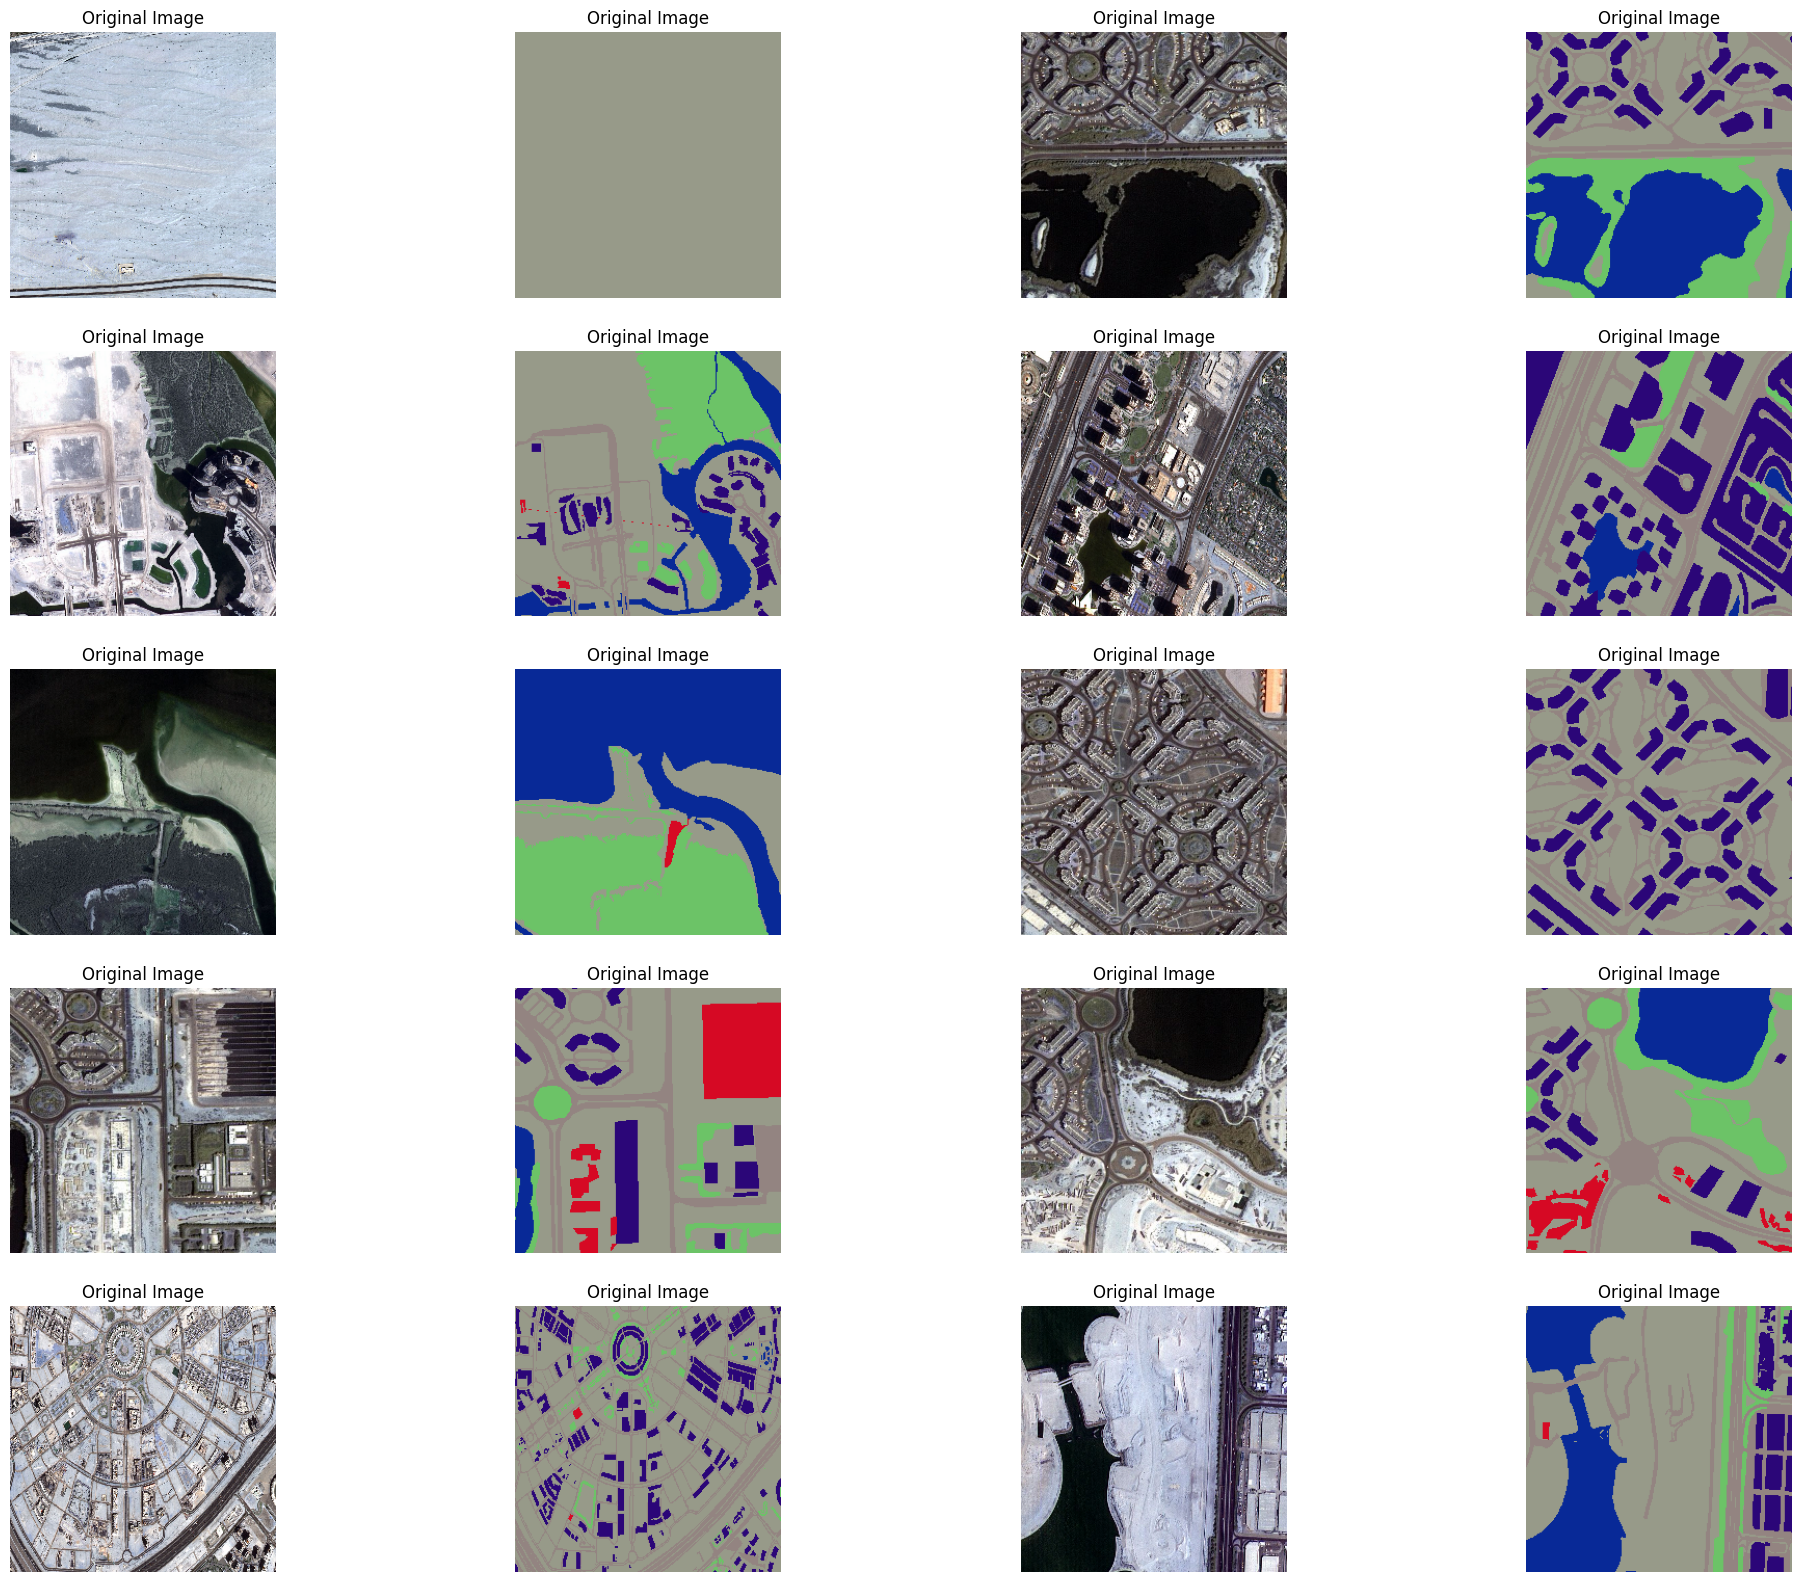

In [2]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)


### Training Setup

In [3]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 868.5 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ec721f8e6c512b808e03a57a5e0c062df5136260f93b0fa2c5f21a51effc7db7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=108b7cb93d914b098c67adec7298b25a513ba7687d555f8b5a9fe37985c3665b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s] 


In [4]:
### Train and Validation

In [4]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 100, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


  0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


Epoch 1 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 4.823 secs
Train Loss         -> 1.191
Train PA           -> 0.642
Train IoU          -> 0.517
Validation Loss    -> 1.307
Validation PA      -> 0.855
Validation IoU     -> 0.747

Loss decreased from inf to 1.307!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 16/16 [00:02<00:00,  7.76it/s]


Epoch 2 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 2.489 secs
Train Loss         -> 0.590
Train PA           -> 0.870
Train IoU          -> 0.742
Validation Loss    -> 1.351
Validation PA      -> 0.741
Validation IoU     -> 0.583

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.71it/s]


Epoch 3 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 2.259 secs
Train Loss         -> 0.433
Train PA           -> 0.901
Train IoU          -> 0.786
Validation Loss    -> 0.424
Validation PA      -> 0.891
Validation IoU     -> 0.802

Loss decreased from 1.351 to 0.424!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.96it/s]


Epoch 4 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 2.225 secs
Train Loss         -> 0.420
Train PA           -> 0.888
Train IoU          -> 0.763
Validation Loss    -> 0.447
Validation PA      -> 0.854
Validation IoU     -> 0.743

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.43it/s]


Epoch 5 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 2.319 secs
Train Loss         -> 0.367
Train PA           -> 0.894
Train IoU          -> 0.768
Validation Loss    -> 0.430
Validation PA      -> 0.865
Validation IoU     -> 0.762

Loss decreased from 0.447 to 0.430!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 16/16 [00:01<00:00,  9.18it/s]


Epoch 6 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 2.202 secs
Train Loss         -> 0.304
Train PA           -> 0.907
Train IoU          -> 0.794
Validation Loss    -> 0.322
Validation PA      -> 0.887
Validation IoU     -> 0.795

Loss decreased from 0.430 to 0.322!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 7 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 2.680 secs
Train Loss         -> 0.266
Train PA           -> 0.920
Train IoU          -> 0.811
Validation Loss    -> 0.353
Validation PA      -> 0.870
Validation IoU     -> 0.766

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.20it/s]


Epoch 8 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 2.402 secs
Train Loss         -> 0.232
Train PA           -> 0.932
Train IoU          -> 0.834
Validation Loss    -> 0.258
Validation PA      -> 0.898
Validation IoU     -> 0.814

Loss decreased from 0.353 to 0.258!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


Epoch 9 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 2.257 secs
Train Loss         -> 0.229
Train PA           -> 0.931
Train IoU          -> 0.825
Validation Loss    -> 0.306
Validation PA      -> 0.882
Validation IoU     -> 0.786

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.69it/s]


Epoch 10 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 2.247 secs
Train Loss         -> 0.196
Train PA           -> 0.939
Train IoU          -> 0.847
Validation Loss    -> 0.351
Validation PA      -> 0.874
Validation IoU     -> 0.773

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.06it/s]


Epoch 11 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 2.395 secs
Train Loss         -> 0.190
Train PA           -> 0.940
Train IoU          -> 0.857
Validation Loss    -> 0.242
Validation PA      -> 0.904
Validation IoU     -> 0.824

Loss decreased from 0.351 to 0.242!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.47it/s]


Epoch 12 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 2.303 secs
Train Loss         -> 0.206
Train PA           -> 0.936
Train IoU          -> 0.836
Validation Loss    -> 0.327
Validation PA      -> 0.874
Validation IoU     -> 0.773

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.01it/s]


Epoch 13 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 2.407 secs
Train Loss         -> 0.225
Train PA           -> 0.923
Train IoU          -> 0.816
Validation Loss    -> 0.383
Validation PA      -> 0.862
Validation IoU     -> 0.754

Loss did not decrease for 7 epoch(s)!
Stopping training process becuase loss value did not decrease for 7 epochs!
Train process is completed in 0.562 minutes.


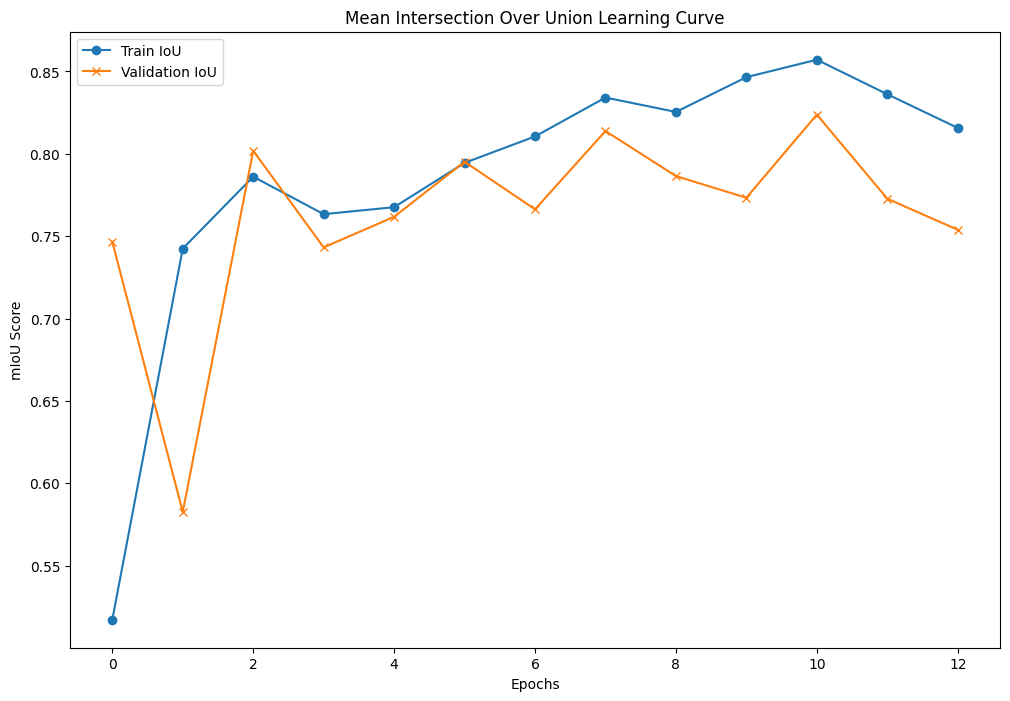

<Figure size 640x480 with 0 Axes>

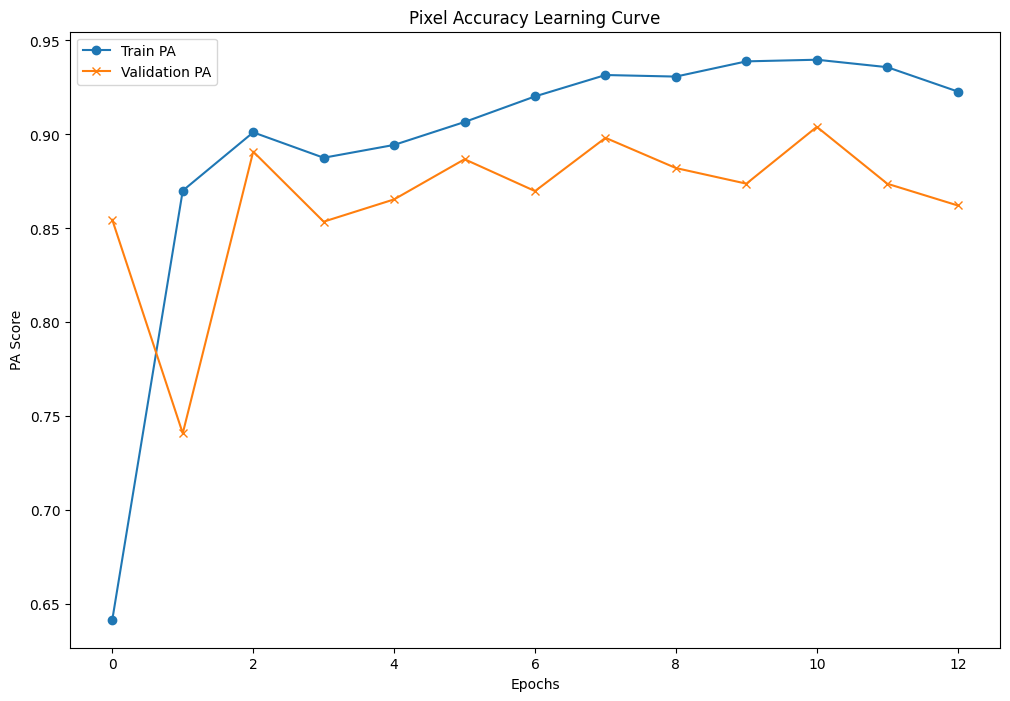

<Figure size 640x480 with 0 Axes>

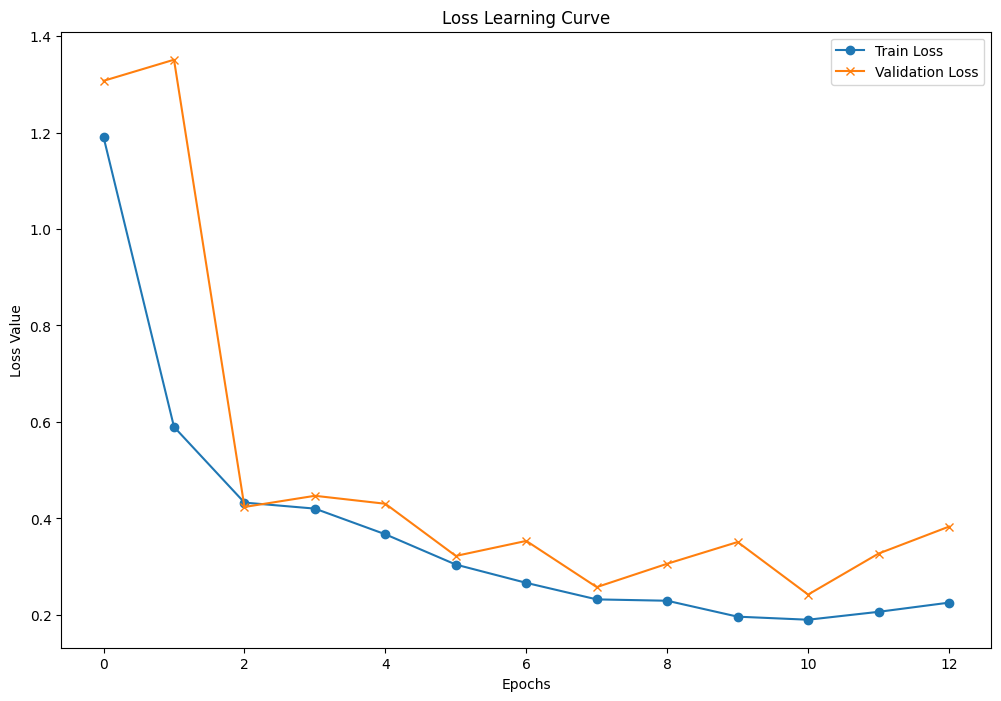

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        # Plotting the Mean Intersection Over Union Learning Curve
        self.visualize(metric1="tr_iou", metric2="val_iou", label1="Train IoU", 
                       label2="Validation IoU", ylabel="mIoU Score", 
                       title="Mean Intersection Over Union Learning Curve")
        
        # Plotting the Pixel Accuracy Learning Curve
        self.visualize(metric1="tr_pa", metric2="val_pa", label1="Train PA", 
                       label2="Validation PA", ylabel="PA Score", 
                       title="Pixel Accuracy Learning Curve")
        
        # Plotting the Loss Learning Curve
        self.visualize(metric1="tr_loss", metric2="val_loss", label1="Train Loss", 
                       label2="Validation Loss", ylabel="Loss Value", 
                       title="Loss Learning Curve")
        
    def plot(self, metric, label, marker): 
        plt.plot(self.res[metric], label=label, marker=marker)
    
    def decorate(self, ylabel, title): 
        plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        plt.figure(figsize=(12, 8))
        self.plot(metric1, label1, marker='o')
        self.plot(metric2, label2, marker='x')
        self.decorate(ylabel, title)
        
        # Saving the plot to PDF with DPI=600 and bbox_inches='tight'
        plt.savefig(f"{title.replace(' ', '_').lower()}.pdf", dpi=600, bbox_inches='tight')
Plot(history)


### Inference

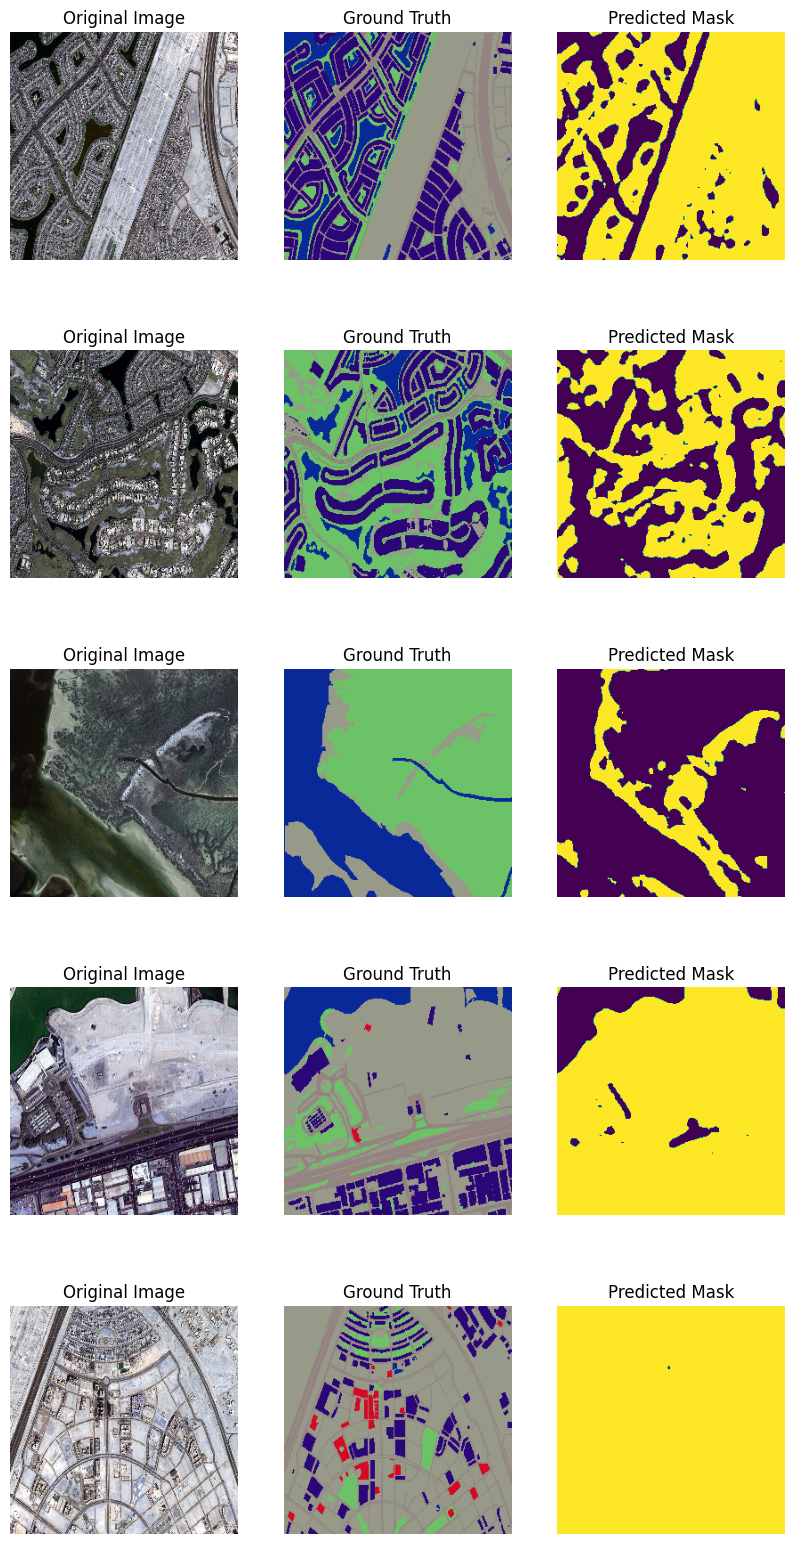

In [6]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (10, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load("/kaggle/working/saved_models/aerial_best_model.pt")
inference(test_dl, model = model, device = device)

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
model_path = "/kaggle/working/saved_models/aerial_best_model.pt"
model = torch.load(model_path)
model.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize input image to model's expected size
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to process input image
def process_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

import numpy as np

import numpy as np

# Function to post-process the model output to generate a valid image with specific colors
def postprocess_output(output):
    # Assuming output shape is (num_classes, height, width)
    # Convert probability map to class labels by taking argmax along the channel axis
    predicted_class = np.argmax(output, axis=0)
    
    # Create an RGB image
    h, w = predicted_class.shape
    output_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Define colors
    yellow_color = np.array([255, 255, 0])  # Yellow color
    purple_color = np.array([128, 0, 128])  # Purple color

    # Assign colors based on predicted classes
    output_image[np.where(predicted_class == 1)] = yellow_color  # Assuming class 1 represents detection
    output_image[np.where(predicted_class == 0)] = purple_color  # Assuming class 0 represents background

    return output_image

# Function to display output image
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
# Example usage
input_image_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg"  # Replace with your input image path
input_image = process_image(input_image_path)
output_image = model(input_image)
processed_output_image = postprocess_output(output_image)
display_image(processed_output_image)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor